# CSI 6160 Homework 4
### Samantha Bracellari & Justin Kur

For this assignment, we used a binary classification dataset with over 200k samples, each with 21 features, that describes the likelihood of a given person (sample) having heart disease.
The dataset can be found here: 
https://www.kaggle.com/datasets/alexteboul/heart-disease-health-indicators-dataset

We apply any necessary preprocessing on the data (i.e. scaling columns, weighting them for enhanced model performance, etc.) and then finish by performing 5-fold cross validation and splitting the data into train and test sets. 80% of the data will be used for training, while the remaining 20% will be used for testing.

In [1]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, f1_score
import polars as pl
import itertools

TARGET = "HeartDiseaseorAttack"

def fetch_data(df, use_split, rbf=False, scale_col=True, combine_bool=False):
    assert(use_split >= 0 and use_split <= 4)
    # Perform 5-fold cross validation with a deterministic seed
    kf = KFold(n_splits=5, shuffle=True, random_state=2023)
    splits = list(kf.split(df))
    # Indexing the dataframe with an array returns the appropriate splits
    df_train, df_test = df[splits[use_split][0]], df[splits[use_split][1]]
    if scale_col:
        for col in df_train.columns:
            if col == TARGET:
                continue
            df_train, df_test = scale_column(df_train, df_test, col)
    cols = list(df_train.columns)
    binary = binary_columns(df_train)
    if rbf:
        for col in cols:
            if col == TARGET or col in binary:
                continue
            df_train, df_test = rbf_column(df_train, df_test, col) # Use radial bias function
    if combine_bool:
        for (col_a, col_b) in itertools.combinations(binary, 2):
            if col_a == TARGET or col_b == TARGET:
                continue
            df_train, df_test = mul_cols(df_train, df_test, col_a, col_b)
    return df_train, df_test

def binary_columns(df):
    binary = []
    for col in df.columns:
        if df.get_column(col).n_unique() == 2:
            binary.append(col)
    return binary

def scale_column(df_train, df_test, col_name):
    '''Scale a column from 0 to 1'''
    max = df_train.get_column(col_name).max()
    min = df_train.get_column(col_name).min()
    df_train = df_train.with_columns((pl.col(col_name) - min) / (max - min))
    df_test = df_test.with_columns((pl.col(col_name) - min) / (max - min))
    return df_train, df_test

def rbf_column(df_train, df_test, col_name):
    '''Divide a col into 3 features using a radial basis function'''
    std = df_train.get_column(col_name).std()
    low = df_train.get_column(col_name).quantile(0.25)
    middle = df_train.get_column(col_name).quantile(0.5)
    high = df_train.get_column(col_name).quantile(0.75)
    for i, val in enumerate([low, middle, high]):
        df_train = df_train.with_columns((-1.0 * (pl.col(col_name) - val)**2 / (2 * std)**2).exp().alias(f"{col_name}_{i}"))
        df_test = df_test.with_columns((-1.0 * (pl.col(col_name) - val)**2 / (2 * std)**2).exp().alias(f"{col_name}_{i}"))
    return df_train.drop(col_name), df_test.drop(col_name)

def mul_cols(df_train, df_test, col_a, col_b):
    df_train = df_train.with_columns((pl.col(col_a) * pl.col(col_b)).alias(f"{col_a}+{col_b}"))
    df_test = df_test.with_columns((pl.col(col_a) * pl.col(col_b)).alias(f"{col_a}+{col_b}"))
    return df_train, df_test

def get_x_y(df):
    X, y = df.drop(TARGET), df.get_column(TARGET)
    X = X.with_columns(pl.lit(1.0).alias('constant')) # extra column for the bias term
    return X.to_numpy(), y.to_numpy()

df = pl.read_csv("heart_disease.csv", has_header=True)

df_train, df_test = fetch_data(df, 0)
X_train, y_train = get_x_y(df_train)
X_test, y_test = get_x_y(df_test)
df_train.tail()

HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,1.0,1.0,1.0,0.383721,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.5,0.0,0.166667,0.0,1.0,0.333333,1.0,0.857143
0.0,1.0,1.0,1.0,0.069767,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.75,0.0,0.0,1.0,0.0,0.833333,0.2,0.428571
0.0,0.0,0.0,1.0,0.186047,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.8,0.142857
0.0,1.0,0.0,1.0,0.127907,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.5,0.0,0.0,0.0,1.0,0.5,0.8,0.0
1.0,1.0,1.0,1.0,0.151163,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.666667,1.0,0.142857


In [2]:
unbalanced = ((y_train == 1).sum() / len(y_train)).item()
print(f"Percentage of Heart Disease Examples: {100 * unbalanced:.1f}%")

Percentage of Heart Disease Examples: 9.4%


In [3]:
print(f"Percentage of binary features: {100 * len(binary_columns(df_train)) / len(df_train.columns):.1f}%")

Percentage of binary features: 63.6%


The goal of this dataset is to predict heart disease or heart attack from a list of predictive features. The dataset is available at https://www.kaggle.com/datasets/alexteboul/heart-disease-health-indicators-dataset . This is a binary classification problem. The main challenges of the dataset are outlined above. Firstly, the dataset is highly unbalanced, with less than 10% of examples showing heart disease or heart attack. Secondly, we have to work with a large number of binary features. This is not necessarily a general challenge in ML, but it is a challenge with a logistic regression model, because it does not have the depth to combine multiple binary features together in complex ways. As such, we are somewhat implicitly relying on the features being relatively independent of one another. This limitation can be overcome with more advanced techniques like intelligent feature construction, kernel functions, etc, but that is not the main focus of this work. 

### Helper Functions & Building Blocks

Below we have defined the Sigmoid function, which is what transforms a linear regression problem into a logistic one, as well as error and error gradient calculations, and a stochastic gradient descent algorithm.

These are all of the building blocks needed to implement a logistic regression model.

In [4]:
import numpy as np

def sigmoid(x):
    # Simple check to avoid numerical errors with extreme x values
    if x > 1e4:
        return 1.0
    elif x < -1e4:
        return 0.0
    return 1./(1. + np.exp(-x))

def error(x, y, w):
    inside = sigmoid(np.dot(w, x))
    # Avoid overflow / invalid answers from logarithm function
    if inside == 0.0:
        if y == 1:
            return 10000000.0
        else:
            return 0.0
    elif inside == 1.0:
        if y == 1:
            return 0.0
        else:
            return 10000000.0
    
    return -(y * np.log(inside) + (1 - y) * np.log(1 - inside))

def error_gradient(x, y, w, lamb, scale_grad=1.0):
    # Optionally, scale the loss of the rare class
    scale = max(1.0, scale_grad * y)
    return scale * x * (sigmoid(np.dot(w, x)) - y) + lamb * w # Slides seem wrong, gradient should point towards 0 weight

def sgd(X, Y, lr, lamb=0, epochs=2, scale_grad=1.0):
    w = np.random.random(size=X[0].size)
    err_avg = []

    for _ in range(epochs):
        err = []
        for (x, y) in zip(X, Y):
            w = w - lr * error_gradient(x, y, w, lamb, scale_grad=scale_grad)
            err.append(error(x, y, w))
        err_avg.append(np.mean(err))
    
    return w, err_avg

### Logistic Regression Implementation

Once we have defined the functions above, the rest is generally pretty straightforward:

- calculate the updated weights and errors using SGD
- keep track of the error for visualization purposes

Since we're using a grid search to find the best lambda value, we are also keeping a note of the weight vector at each lambda value to determine the best one.

In [5]:
# Lambdas are very low since the weight penalty is being applied on every sgd step
l = [1e-6, 1e-5, 1e-4]

def logistic_regression(X, y, lambdas, scale_grad=1.0):
    weights, errors = [], []
    for l in lambdas:
        w, err = sgd(X, y, 5e-3, lamb=l, scale_grad=scale_grad)
        weights.append(w)
        errors.append(err)
    return weights, errors

weights, errors = logistic_regression(X_train, y_train, l)

## Experimenting & Benchmarking

To measure the accuracy of our model, we use the F1 score to determine how 
precisely the model was able to predict weights that achieved a value closest to the target when 
used with the linear model. We ran the model against the train sets to collect all of the potential 
weight vectors, and then used those weight vectors with the test sets to calculate the F1 score.

As we usually do, we also benchmarked against Sci-Kit Learn's logistic regression model and F1 score.

In [6]:
from sklearn.linear_model import LogisticRegression

class Score:
    def __init__(self, preds, y):
        self.score = (np.count_nonzero(preds == y)) / len(y)
        self.conf = confusion_matrix(y, preds)
        self.f1 = f1_score(y, preds)

def score(X, y, w):
    preds = np.array([sigmoid(np.dot(x, w)) for x in X])
    preds = np.rint(preds)
    return Score(preds, y)

def run_experiment(df, use_split, lambdas, rbf=False, scale_grad=1.0, combine_bool=False):
    df_train, df_test = fetch_data(df, use_split, rbf=rbf, combine_bool=combine_bool)
    X_train, y_train = get_x_y(df_train)
    X_test, y_test = get_x_y(df_test)
    all_weights, _ = logistic_regression(X_train, y_train, lambdas, scale_grad=scale_grad)
    scores = [score(X_test, y_test, w) for w in all_weights]
    return scores

def sk_bench(df, use_split, rbf=False):
    df_train, df_test = fetch_data(df, use_split, rbf=rbf)
    X_train, y_train = get_x_y(df_train)
    X_test, y_test = get_x_y(df_test)
    model = LogisticRegression(solver='newton-cg', random_state=0).fit(X_train, y_train)
    pred = model.predict(X_test)
    return Score(pred, y_test)

In [7]:
experiments = [run_experiment(df, x, l, rbf=False) for x in range(5)]

We found for this dataset that very small lambda values for weight decay actually improve performance. At the same time, however, we see relatively small L2 Norm values for the weights, at only 6.3 at the highest. Since our input features are scaled from 0 to 1, this norm value seems reasonably low. This means that high weight decay is not seemingly necessary to keep weights from exploding on this dataset, and higher lambda values just decrease performance rather than improving regularization. 

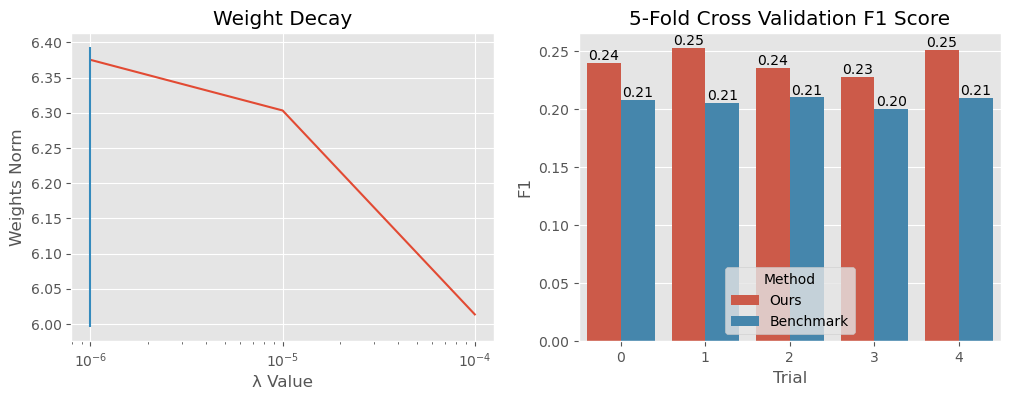

In [8]:
import seaborn
import pandas as pd 
import matplotlib.pyplot as plt

plt.style.use('ggplot')
scores = np.stack([[x.f1 for x in list] for list in experiments])

COLORS = seaborn.color_palette()
f, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(l, [np.linalg.norm(x) for x in weights], color=COLORS[0])
ax[0].vlines(l[scores.mean(axis=0).argmax()], ymin=ax[0].get_ylim()[0], ymax=ax[0].get_ylim()[1], color=COLORS[1])
ax[0].set_xscale('log')
ax[0].set_ylabel('Weights Norm')
ax[0].set_xlabel('λ Value')
ax[0].set_title('Weight Decay')

our_method = scores.max(axis=1).tolist()
benchmark = [sk_bench(df, x, rbf=False).f1 for x in range(5)]
method = ['Ours' for _ in range(5)] + ['Benchmark' for _ in range(5)]
plot_df = pd.DataFrame.from_dict({'F1': our_method + benchmark, 'Method': method, 'Trial': list(range(5)) + list(range(5))})
ax[1].set_title('5-Fold Cross Validation F1 Score')
seaborn.barplot(data=plot_df, x='Trial', y='F1', hue='Method', ax=ax[1], palette=COLORS)
seaborn.move_legend(ax[1], "lower center")
for container in ax[1].containers:
    ax[1].bar_label(container, fmt="%.2f")

In [9]:
weights[0]

array([ 0.63852998,  0.54185131, -0.28062758, -0.63595796,  0.28941332,
        1.0272924 ,  0.33618185,  0.0622611 ,  0.11826357, -0.08013337,
       -0.37439923, -0.29380884,  0.18321748,  1.74370718,  0.1253958 ,
        0.20436935,  0.3627553 ,  0.62712405,  2.6727832 , -0.20250317,
       -0.34932221, -5.1954367 ])

We can see that the precision is high for both classes, but the recall is very low for the value of 1 (heart disease or heart attack). This is to be expected since the dataset is unbalanced, with 90% of cases in the zero class. We can try to improve this by setting different weights for the two classes. 

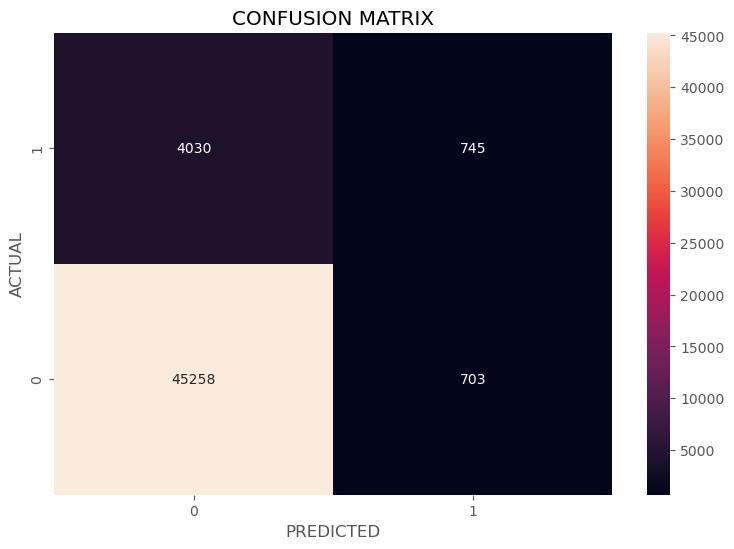

In [10]:
plt.figure(figsize = (9,6))
ax = seaborn.heatmap(experiments[0][0].conf, annot=True, fmt='g')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')
plt.title('CONFUSION MATRIX')
ax.set_ylim(0, 2)
plt.show()

In [11]:
scale = np.linspace(1, 5, 9)
scale_loss_exp = [run_experiment(df, 0, [l[0]], rbf=False, scale_grad=x) for x in scale]

We see that modifying the weight for the heart disease class makes a positive tradeoff in improving recall at the expense of precision (at least using the F1 score metric), until the weight finally becomes so high that the additional recall is not worth the precision loss. For further experiments we select this best experimentally found value of 3.5

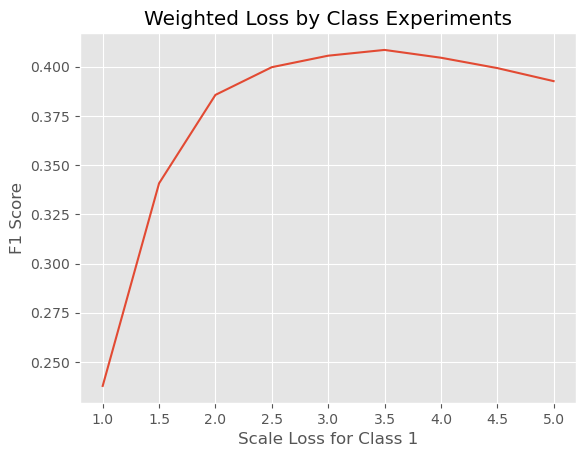

In [12]:
y_vals = [scale_loss_exp[i][0].f1 for i in range(len(scale_loss_exp))]
x = scale
f, ax = plt.subplots()
ax.set_ylabel("F1 Score")
ax.set_xlabel("Scale Loss for Class 1")
ax.set_title("Weighted Loss by Class Experiments")
ax.plot(x, y_vals)

Finally, we try to improve performance with more intelligent feature construction. We first try a radial basis function (RBF), which breaks each feature into multiple values along multiple Gaussian curves. We exclude the boolean features from this because it does not make sense to scale them to a Gaussian distribution (in early experiments we confirmed that this significantly damages performance, as expected).

Even with the filtering of boolean columns, however, the RBF appears to only slightly lower our overall F1 score performance. 

In [13]:
rbf_exp = [run_experiment(df, x, l, rbf=True, scale_grad=3.5) for x in range(5)]
experiments = [run_experiment(df, x, l, rbf=False, scale_grad=3.5) for x in range(5)]

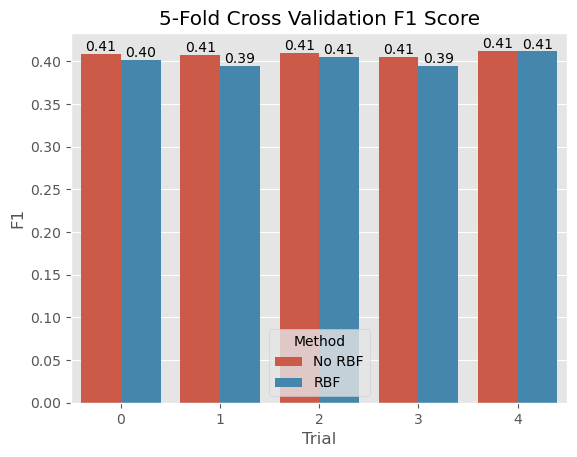

In [14]:
plt.style.use('ggplot')
scores = np.stack([[x.f1 for x in list] for list in experiments])
rbf_scores = np.stack([[x.f1 for x in list] for list in rbf_exp])

COLORS = seaborn.color_palette()
f, ax = plt.subplots()

no_rbf = scores.max(axis=1).tolist()
rbf = rbf_scores.max(axis=1).tolist()

method = ['No RBF' for _ in range(5)] + ['RBF' for _ in range(5)]
plot_df = pd.DataFrame.from_dict({'F1': no_rbf + rbf, 'Method': method, 'Trial': list(range(5)) + list(range(5))})
ax.set_title('5-Fold Cross Validation F1 Score')
seaborn.barplot(data=plot_df, x='Trial', y='F1', hue='Method', ax=ax, palette=COLORS)
seaborn.move_legend(ax, "lower center")
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f")

With the scaled loss, we tradeoff much better recall for the rare class with a higher false positive rate. 

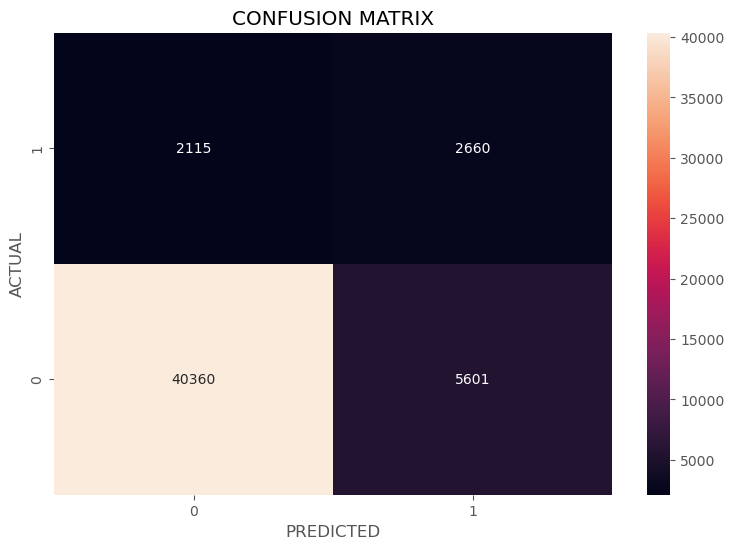

In [15]:
plt.figure(figsize = (9,6))
ax = seaborn.heatmap(experiments[0][0].conf, annot=True, fmt='g')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')
plt.title('CONFUSION MATRIX')
ax.set_ylim(0, 2)
plt.show()

We try one last trick to try to improve performance. Similar to how the radial basis function constructs multiple features out of a single value, we can multiply different (or the same) features together to create new features. Since this dataset has a lot of boolean features, we try combining each of them to get X_1 & X_2, a feature that cannot be directly obtained in a logistic regression. This approach rapidly becomes untenable with large feature spaces since it scales, at minimum, like N^2, but this dataset has few enough features that we can try it. 

Nonetheless, it seems the results are slightly worse than the naive method with no additional feature construction. It may be that this leads to more overfitting of the dataset, but more likely is that the A & B features are not very informative on this dataset.

In [16]:
bool_experiments = [run_experiment(df, x, l, rbf=False, scale_grad=3.5, combine_bool=True) for x in range(5)]

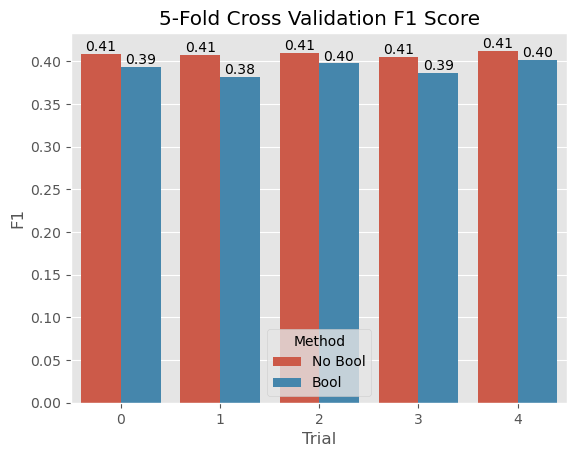

In [17]:
scores = np.stack([[x.f1 for x in list] for list in experiments])
boolean_scores = np.stack([[x.f1 for x in list] for list in bool_experiments])

COLORS = seaborn.color_palette()
f, ax = plt.subplots()

no_boolean = scores.max(axis=1).tolist()
boolean = boolean_scores.max(axis=1).tolist()

method = ['No Bool' for _ in range(5)] + ['Bool' for _ in range(5)]
plot_df = pd.DataFrame.from_dict({'F1': no_boolean + boolean, 'Method': method, 'Trial': list(range(5)) + list(range(5))})
ax.set_title('5-Fold Cross Validation F1 Score')
seaborn.barplot(data=plot_df, x='Trial', y='F1', hue='Method', ax=ax, palette=COLORS)
seaborn.move_legend(ax, "lower center")
# ax.bar_label(container, fmt="%.2f")
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f")